## This is a notebook to walk through the carbon P90 analysis

The notebook will look at the data, analyse the accuracy of the data and then perform a P90 analysis on it

In [5]:
'''
Let us first install the necessary libraries:
(you may have to install these libraries in your virtual environment from the command line)
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# setting to make the plots nicer
import seaborn as sns
sns.set(style="whitegrid")

### Import the Data

Let us now import the data and have a quick look at it

In [3]:
# import data
solar = pd.read_csv('Data/1_month_solar.csv')

# rename columns
solar.rename(columns={'Datetime':'datetime'}, inplace=True)
solar.rename(columns={'Global Horizontal DH3 (W/m^2)':'power'}, inplace=True)

# convert to datetime
solar['datetime'] = pd.to_datetime(solar['datetime'])

# set datetime as index
solar.set_index('datetime', inplace=True)

# remove any negative values
solar['power'].clip(lower=0, inplace=True)

# inspect the data
solar

,power
datetime,
2017-06-01 05:00:00,0.47216
2017-06-01 05:00:01,0.47216
2017-06-01 05:00:02,0.47216
2017-06-01 05:00:03,0.47216
2017-06-01 05:00:04,0.47216
...,...
2017-06-30 19:59:55,0.00000
2017-06-30 19:59:56,0.00000
2017-06-30 19:59:57,0.00000


## Visualise the data

now we know that the data starts at 2017-06-01 05:00:00 and ends at 2017-06-30 19:59:59

Lets look at one days worth of solar generation from the data

we can see below that the output from a solar generator varies greatly over the period of one day

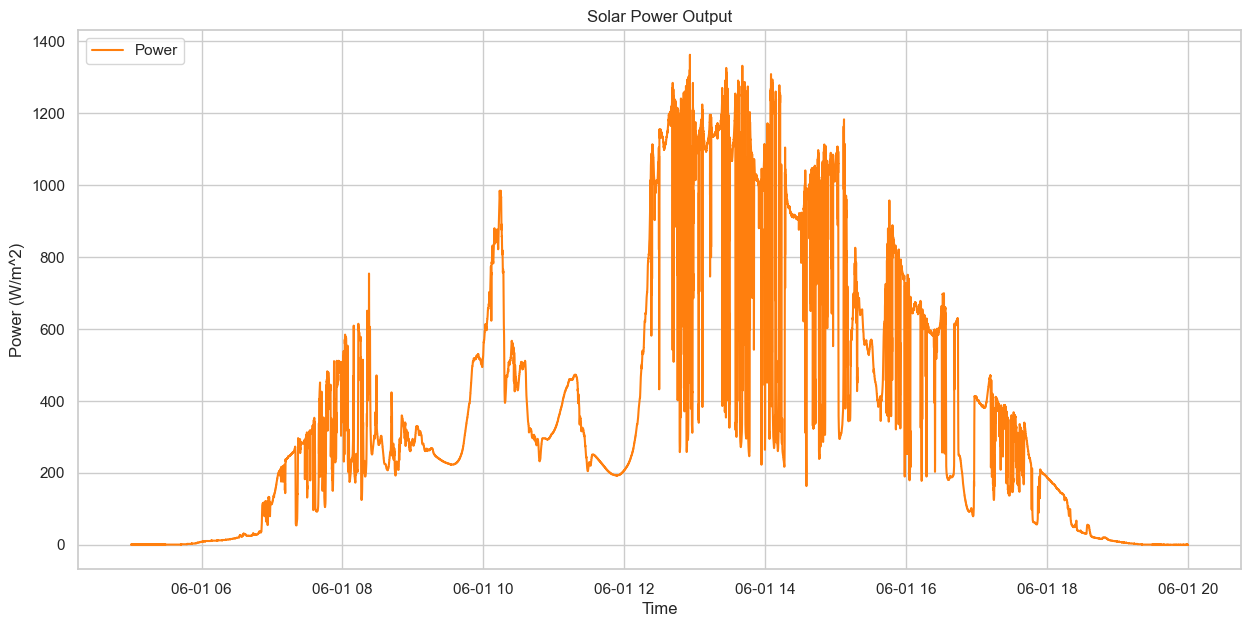

In [11]:
# selsect timeframe to look over
start_dt = datetime(year=2017, month=6, day=1)
end_dt = datetime(year=2017, month=6, day=2)
solar_slice = solar.loc[start_dt:end_dt].copy()

# plot the data
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(solar_slice.index, solar_slice['power'], color='tab:orange')
ax.set_xlabel('Time')
ax.set_ylabel('Power (W/m^2)')
ax.set_title('Solar Power Output')
ax.legend(['Power'], loc='upper left')


## Visualise the inaccuracy

let us choose a matching period and visualise the discrepancy between the solar generation and a flat demand profile 

p.s. in a real scenario the demand would also be varying and would further decrease the accuracy

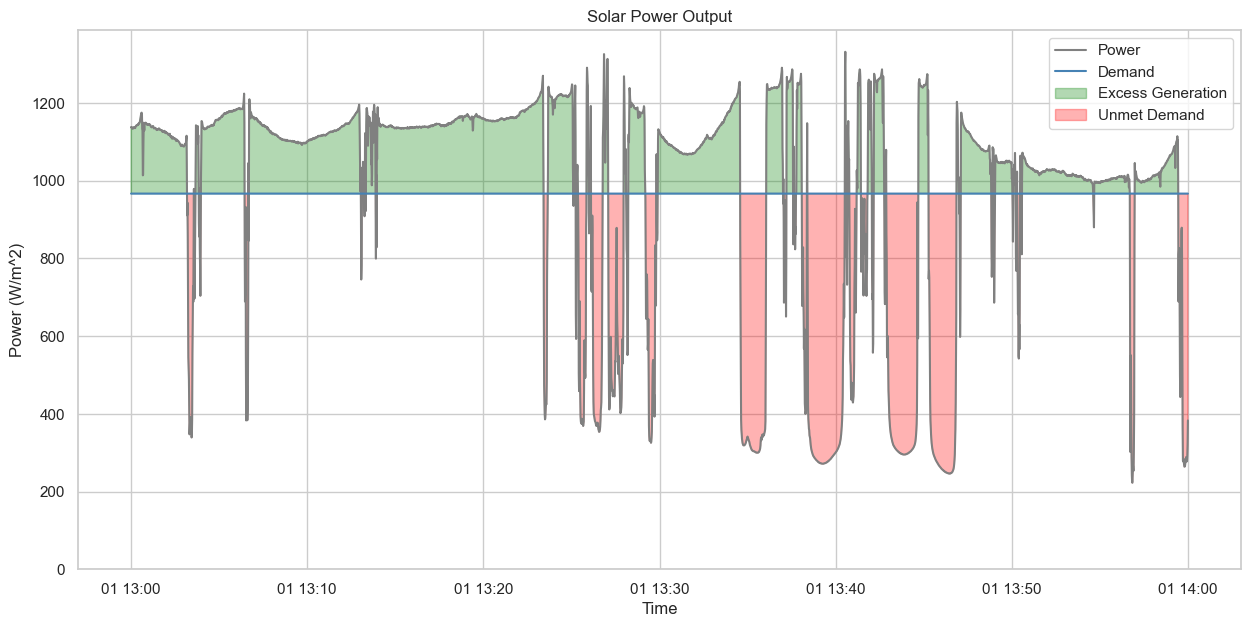

In [24]:
# choose matching period
matching_period = timedelta(minutes=60)

start_dt = datetime(year=2017, month=6, day=1, hour=13)
end_dt = start_dt + matching_period
solar_slice = solar.loc[start_dt:end_dt].copy()

# create column with the average of the power
solar_slice['demand'] = solar_slice['power'].mean()

# plot the data
fig, ax = plt.subplots(figsize=(15,7))

# Plot solar power
ax.plot(solar_slice.index, solar_slice['power'], color='grey', label='Power')

# Plot demand
ax.plot(solar_slice.index, solar_slice['demand'], color='steelblue', label='Demand')

# Shade the area where solar is greater than demand in green
ax.fill_between(solar_slice.index, solar_slice['demand'], solar_slice['power'], where=solar_slice['power'] > solar_slice['demand'], interpolate=True, color='green', alpha=0.3, label='Excess Generation')

# Shade the area where solar is less than demand in red
ax.fill_between(solar_slice.index, solar_slice['demand'], solar_slice['power'], where=solar_slice['power'] < solar_slice['demand'], interpolate=True, color='red', alpha=0.3, label='Unmet Demand')

ax.set_xlabel('Time')
ax.set_ylabel('Power (W/m^2)')
ax.set_ylim(0)
ax.set_title('Solar Power Output')
ax.legend(loc='best')
ax.set_ylim(0)

plt.show()

The graph above visualises the mismatch between the demand and generation profiles. Any mismatch, deficit (red) or excess (green) results in an imbalance on the grid that requires the grid operator to correct. 

For the consumer who has the demand profile as shown in the graph, it would be inaccurate to say that all of their energy in this matching period is coming from the solar generation. In this scenario it would only be accurate to say that the amount shaded blue in the graph below is coming from the solar generation, and hence zero carbon, even though the total amount of demand is equal to the total amount of generation.

let us quantify the actual amount of energy that is sourced from the solar:

The solar met 87.87% of the demand during this period.


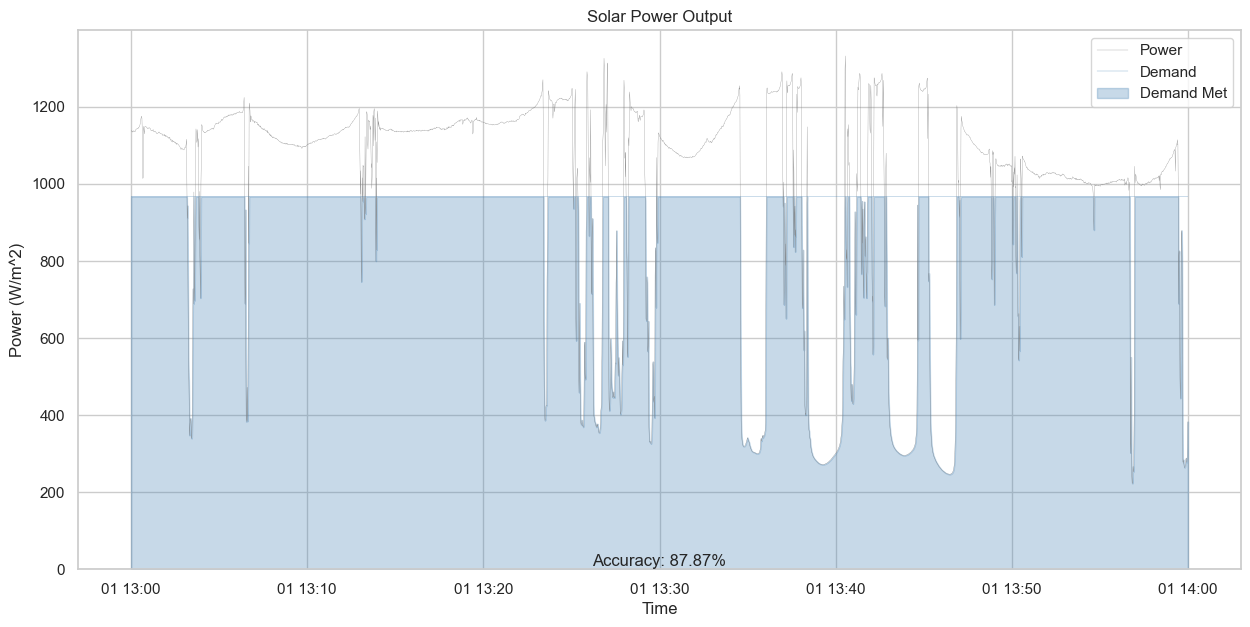

In [47]:
# quantify the percentage of demand met by the solar
solar_slice['demand_met'] = solar_slice['power'] / solar_slice['demand'] * 100

# get rid of values greater than 100%
solar_slice['demand_met'].clip(upper=100, inplace=True)

# ascertain the percentage of demand met
accuracy = solar_slice['demand_met'].mean()

print('The solar met {:.2f}% of the demand during this period.'.format(accuracy))

# plot and shade the demand met
fig, ax = plt.subplots(figsize=(15,7))

# Plot solar power
ax.plot(solar_slice.index, solar_slice['power'], color='grey', label='Power', linewidth=0.2)

# Plot demand
ax.plot(solar_slice.index, solar_slice['demand'], color='steelblue', label='Demand', linewidth=0.2)

# shade the area defined from 0 to demand met
ax.fill_between(solar_slice.index, 0, solar_slice['demand_met']*solar_slice['demand'].mean()/100, color='steelblue', alpha=0.3, label='Demand Met')

ax.set_xlabel('Time')
ax.set_ylabel('Power (W/m^2)')
ax.set_ylim(0)
ax.set_title('Solar Power Output')
ax.legend(loc='best')

# state the accuracy on the plot in the bottom middle of the plot
ax.text(solar_slice.index[0] + matching_period/2, 0, 'Accuracy: {:.2f}%'.format(accuracy), horizontalalignment='center', verticalalignment='bottom')

plt.show()

## Determine the accuracy of each matching period within the month's data

now we have visualised and determined the accuracy of this specific matching period, we need to repeat this process for each matching period within the month's data

In [49]:
'''
we know that each days worth of data goes from 5am -> 8pm, and that the first day is the 1st of June 2017.
'''
# print the matching period that we are using
print('Matching Period: {}'.format(matching_period))

year = 2017
month = 6
day = 1
hour = 5
start_dt = datetime(year=year, month=month, day=day, hour=hour)
end_dt = start_dt + matching_period

solar_slice = solar.loc[start_dt:end_dt].copy()


Matching Period: 1:00:00
